## Code for scraping PredictionBook and dumping question data into pickle files - took about 7-8 hours on my PC

In [83]:
# This is just an adapted version of the code in https://niplav.github.io/range_and_forecasting_accuracy.html
# put through a python 2 to 3 converter with a few tweaks to get more data e.g. usernames

import urllib.request, urllib.error, urllib.parse
import sys
import time
import pickle 

from bs4 import BeautifulSoup
from time import mktime
def showforecasts(linkp, res):
    forecastsdict=dict()
    urlp="https://predictionbook.com{}".format(linkp)
    reqp=urllib.request.Request(urlp, headers={"User-Agent" : "Firefox"})
    try:
        conp=urllib.request.urlopen(reqp, timeout=10)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        return
    datap=conp.read()
    soupp=BeautifulSoup(datap, "html.parser")

    timedata=soupp.find(lambda tag:tag.name=="p" and "Created by" in tag.text)
    resolved=timedata.find("span", class_="judgement").find("span", class_="date created_at").get("title")
    restime=time.strptime(resolved,"%Y-%m-%d %H:%M:%S UTC")
    created=timedata.find("span", class_="date").get("title")
    createtime=time.strptime(created,"%Y-%m-%d %H:%M:%S UTC")
    title=soupp.find('title').get_text().replace("PredictionBook: ", "")
    responses=soupp.find_all("li", class_="response")
    i=1
    for r in responses:
        forecasts=r.find_all("span", class_="confidence")
        if forecasts!=[]:
            est=float(r.find_all("span", class_="confidence")[0].text.strip("%"))/100
        else:
            continue
        estimated=r.find("span", class_="date").get("title")
        esttime=time.strptime(estimated,"%Y-%m-%d %H:%M:%S UTC")
        user = r.find_all("a",class_="user")[0].get_text()
        forecastsdict[(linkp.replace("/predictions/", ""),i)]=[linkp.replace("/predictions/", ""),title, user, mktime(restime)-mktime(createtime), res, est, mktime(restime)-mktime(esttime)]
        i+=1
    with open('pbook2/'+linkp.replace("/predictions/", "")+'.p', 'wb') as fp:
        pickle.dump(forecastsdict, fp, protocol=pickle.HIGHEST_PROTOCOL)
for page in range(1,400):
    url="https://predictionbook.com/predictions/page/{}".format(page)
    req=urllib.request.Request(url, headers={"User-Agent" : "Firefox"})
    try:
        con=urllib.request.urlopen(req)
    except (urllib.error.HTTPError, urllib.error.URLError) as e:
        continue
    data=con.read()
    soup=BeautifulSoup(data, "html.parser")
    predright=soup.find_all("li", {"class": "prediction right"})
    predwrong=soup.find_all("li", {"class": "prediction wrong"})
    for pred in predright:
        try:
            if os.path.exists('pbook2/'+linkp.replace("/predictions/", "")+'.p'):
                continue
            else:
                linkp=pred.span.a.get("href")
                showforecasts(linkp, "1.0")
        except timeout:
            continue
    for pred in predwrong:
        try:
            if os.path.exists('pbook2/'+linkp.replace("/predictions/", "")+'.p'):
                continue
            else:
                linkp=pred.span.a.get("href")
                showforecasts(linkp, "0.0")
        except timeout:
            continue

KeyboardInterrupt: 

## Once you've got the data in files, everything else is faster

In [347]:
from sklearn.linear_model import LinearRegression
import urllib.request, urllib.error, urllib.parse
import sys
import time
import pickle 
import os
import pandas as pd, numpy as np
from bs4 import BeautifulSoup
from time import mktime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
def overconfidence(sample):
    # metaculus overconfidence score
    num=0
    denom=0
    for pred in sample:
        num+=(pred-1)*(pred-.5)
        denom+=(pred-.5)*(pred-.5)
    return num/denom
def pofr(p,r):
    # get prediction's P(result) given prediction and result in {0,1}
    if r==0.:
        return 1-p
    elif r==1.:
        return p
    else:return None
    
def EBrier(pred):
    # expected Brier score if perfectly calibrated
    return pred*(1-pred)*(1-pred)+(1-pred)*pred*pred

def frequencyofprediction(count):
    if count<1.5:
        return "1"
    elif count<4.5:
        return "2-4"
    elif count<10.5:
        return "5-10"
    elif count <25.5:
        return "11-25"
    elif count <100.5:
        return "26-100"
    elif count >100.5:
        return "100+"
    
def calibrations(frame):
    # split predictions into 10 buckets [0-.1], [.1-.2] etc. and for each bucket return the % resolved positively
    calib=dict()
    for i in range(10):
        bucket=frame[frame.Prediction>i/10.][frame.Prediction<i/10.+.1]
        score=np.mean(bucket.Result)
        calib[i/10.+.05]=score
    return pd.DataFrame.from_dict(calib, orient="index")

def scaledpred(user, pred, table=scaleuser):
    #scale a prediction by the group overconfidence
    if pred<.5:
        return (.5-pred)*(table[user])+pred
    else:
        return (pred-.5)*(1-table[user])+.5

### Pull predictions from pickles

In [78]:
files=os.listdir('pbook2/')

In [79]:
questions=dict()
for file in files:
    qid=int(file[:-2])
    with open('pbook2/'+file, 'rb') as fp:
        questions[qid] = pickle.load(fp)

In [80]:
len(questions.keys())

14033

In [85]:

predictions=dict()
for qid in questions.keys():
    for key in questions[qid]:
        key2=(int(key[0]), int(key[1]))
        predictions[key2]=questions[qid][key]

In [88]:
for key in predictions.keys():
    predictions[key][3]=predictions[key][3]/86400
    predictions[key][-1]=predictions[key][-1]/86400

In [857]:
predictions

### the main dataframe of predictions, very poorly named, sorry

In [745]:
preddict=pd.DataFrame.from_dict(predictions, orient="index", columns=["QID","Question", "Predictor","OpenFor", "Result", "Prediction", "PredFor"])

In [746]:
preddict.index=pd.MultiIndex.from_tuples(preddict.index)

In [98]:
preddict.sort_index(ascending=True, level=0)

,,QID,Question,Predictor,OpenFor,Result,Prediction,PredFor,Brier
1,1,1,PredictionBook will have an Alpha server runni...,Matt,54.946111,1.0,0.80,54.946111,0.0400
2,1,2,ASX will finish above 5440,Frank,42.195000,0.0,0.60,42.195000,0.3600
3,1,3,Sype video will not work next time,Natalie,42.194051,0.0,0.80,42.194051,0.6400
4,1,4,"The epiode ""11"" of scrubs Series 7 we have jus...",Natalie,42.192998,0.0,0.80,42.192998,0.6400
5,1,5,We will have validation of result dates,Adam,42.173264,1.0,0.70,42.173264,0.0900
...,...,...,...,...,...,...,...,...,...
204361,1,204361,"Personal, Productivity - I read and make Anki ...",jbeshir,1.063032,1.0,0.80,1.063032,0.0400
204369,1,204369,Facebook's Oversight Board will rule to reinst...,lithp,0.809595,0.0,0.70,0.809595,0.4900
204376,1,204376,"Personal, Productivity - I read, make Anki car...",jbeshir,2.484201,1.0,0.82,2.484201,0.0324
204477,1,204477,"Personal, Productivity - I do practice questio...",jbeshir,0.262824,1.0,0.80,0.262824,0.0400


In [747]:
preddict.Result=preddict.Result.apply(lambda x:float(x))

In [748]:
preddict["EBrier"]=preddict.Prediction.apply(lambda x: EBrier(x))

In [749]:
preddict["Brier"]=(preddict["Result"]-preddict["Prediction"])*(preddict["Result"]-preddict["Prediction"])

In [750]:
#P assigned to the actual outcome which occurred, 
#i.e. a 10% chance of something which didnt happen is mapped to 90%
preddict["OutcomeP"]=preddict[["Prediction", "Result"]].apply(lambda x: pofr(*x), axis=1)

### get user profiles

In [95]:
guessers=preddict["Predictor"].unique()

In [588]:
byuser=dict()
for guesser in guessers:
    byuser[guesser]=preddict[preddict.Predictor==guesser]

In [590]:
profiles=dict()
for guesser in guessers:
    profiles[guesser]=[len(byuser[guesser].index),len(byuser[guesser].QID.unique()), np.mean(byuser[guesser].PredFor), np.mean(byuser[guesser].Brier),  np.mean(byuser[guesser].EBrier),  np.mean(byuser[guesser].ScaledBrier),np.mean(byuser[guesser].GBRBrier),overconfidence(list(byuser[guesser]["OutcomeP"].values))]

In [591]:
profiles=pd.DataFrame.from_dict(profiles,orient="index", columns=["Count","Qs" ,"AvgDuration", "AvgBrier","AvgEBrier", "AvgScaledBrier", "AvgGBRBrier","Overconfidence",])

In [411]:
profiles.sort_values(by="Count").tail(50)

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence
ChristianKl,170,158,568.280,0.122,0.120,0.123,0.009
Oscar_Cunningham,171,170,"1,001.509",0.106,0.097,0.106,0.029
HonoreDB,176,171,533.071,0.117,0.116,0.118,0.003
gimpf,181,175,708.995,0.126,0.120,0.126,0.020
qwerty314,181,173,3.506,0.196,0.173,0.195,0.150
peter_hurford,182,156,205.145,0.150,0.114,0.148,0.131
WilliamKiely,183,75,139.232,0.156,0.138,0.155,0.080
Glenn,184,171,96.921,0.223,0.154,0.219,0.361
John Smith,191,158,95.489,0.153,0.156,0.153,-0.016
Sandra Åhlén,191,180,171.561,0.166,0.174,0.167,-0.057


In [ ]:
profiles["NumPredictions"]=profiles["Count"].apply(lambda x: frequencyofprediction(x))

In [300]:
len(preddict.Predictor.unique())

1846

In [672]:
powerusers=profiles[profiles.Count>100]

In [673]:
np.mean(powerusers.AvgBrier)

0.1526473320101401

In [674]:
np.mean(powerusers.Overconfidence)

0.07393191608454211

In [675]:
np.mean(profiles.AvgBrier)

0.21872149105714644

In [676]:
np.mean(profiles.Overconfidence)

0.4234378325685577

In [153]:
revisors=profiles[profiles.Count-profiles.Qs>0.33*profiles.Qs][profiles.Qs>10]

<ipython-input-153-d8206ecc0082>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  revisors=profiles[profiles.Count-profiles.Qs>0.33*profiles.Qs][profiles.Qs>10]


In [154]:
np.mean(revisors.AvgBrier)

0.17963803539664747

In [677]:
print(len(profiles[profiles.Count==1]),np.mean(profiles[profiles.Count==1]))
print(len(profiles[profiles.Count>1][profiles.Count<=4]),np.mean(profiles[profiles.Count>1][profiles.Count<=4]))
print(len(profiles[profiles.Count>4][profiles.Count<=10]),np.mean(profiles[profiles.Count>4][profiles.Count<=10]))
print(len(profiles[profiles.Count>10][profiles.Count<=25]),np.mean(profiles[profiles.Count>10][profiles.Count<=25]))
print(len(profiles[profiles.Count>25][profiles.Count<=100]),np.mean(profiles[profiles.Count>25][profiles.Count<=100]))
print(len(profiles[profiles.Count>100]),np.mean(profiles[profiles.Count>100]))

615 Count              1.000
Qs                 1.000
AvgDuration      325.198
AvgBrier           0.245
AvgEBrier          0.130
AvgScaledBrier     0.220
AvgGBRBrier        0.243
Overconfidence     0.622
dtype: float64
545 Count              2.659
Qs                 2.521
AvgDuration      299.542
AvgBrier           0.228
AvgEBrier          0.133
AvgScaledBrier     0.209
AvgGBRBrier        0.242
Overconfidence     0.445
dtype: float64
258 Count              6.806
Qs                 6.279
AvgDuration      349.069
AvgBrier           0.212
AvgEBrier          0.134
AvgScaledBrier     0.199
AvgGBRBrier        0.239
Overconfidence     0.326
dtype: float64
182 Count             16.593
Qs                15.313
AvgDuration      337.999
AvgBrier           0.190
AvgEBrier          0.138
AvgScaledBrier     0.184
AvgGBRBrier        0.237
Overconfidence     0.263
dtype: float64
170 Count             50.024
Qs                45.159
AvgDuration      334.681
AvgBrier           0.167
AvgEBrier          0

In [681]:

print(len(profiles[profiles.Count>25][profiles.Count<=100]),np.mean(profiles[profiles.Count>25][profiles.Count<=100]["Overconfidence"]))
print(len(profiles[profiles.Count>100]),np.mean(profiles[profiles.Count>100]["Overconfidence"]))
print(len(profiles[profiles.Count>25][profiles.Count<=100]),np.median(profiles[profiles.Count>25][profiles.Count<=100]["Overconfidence"]))
print(len(profiles[profiles.Count>100]),np.median(profiles[profiles.Count>100]["Overconfidence"]))

170 0.14339065522607017
76 0.07393191608454211
170 0.08154919148860051
76 0.042620870836849845


In [419]:
profiles.head(2)

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence,NumPredictions
refragable,9,8,395.976,0.123,0.191,0.151,-0.575,5-10
Vipul Naik,255,138,128.089,0.165,0.171,0.166,-0.036,100+


In [758]:
preddict["NumPredGroup"]=preddict.Predictor.apply(lambda x: profiles.loc[x]["NumPredictions"])

In [423]:
for group in preddict.NumPredGroup.unique():
    print(group, overconfidence(preddict[preddict.NumPredGroup==group].OutcomeP))

5-10 0.31163893432310147
100+ 0.05608209971735369
2-4 0.38807075571313443
26-100 0.11153689763105092
1 0.4775261236938157
11-25 0.2216138499556959


In [ ]:
preddict["GroupBaseRate"]=preddict["NumPredGroup"].apply(lambda x: preddict.groupby("NumPredGroup").mean().loc[x]["Result"])

In [ ]:
preddict["GBRBrier"]=(preddict["Result"]-preddict["GroupBaseRate"])*(preddict["Result"]-preddict["GroupBaseRate"])

In [ ]:
preddict.groupby("NumPredGroup").mean()

In [442]:
usersummary=profiles.groupby("NumPredictions").mean().sort_values("Count")

In [424]:
usersummary.head()

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence
NumPredictions,,,,,,,
1,1.000,1.000,325.198,0.245,0.130,0.220,0.622
2-4,2.659,2.521,299.542,0.228,0.133,0.209,0.445
5-10,6.806,6.279,349.069,0.212,0.134,0.199,0.326
11-25,16.593,15.313,337.999,0.190,0.138,0.184,0.263
26-100,50.024,45.159,334.681,0.167,0.138,0.165,0.143


In [443]:
usersummary.Overconfidence=usersummary.index.map(lambda x: overconfidence(preddict[preddict.NumPredGroup==x].OutcomeP.values))

In [444]:
usersummary

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence
NumPredictions,,,,,,,
1,1.000,1.000,325.198,0.245,0.130,0.220,0.478
2-4,2.659,2.521,299.542,0.228,0.133,0.209,0.388
5-10,6.806,6.279,349.069,0.212,0.134,0.199,0.312
11-25,16.593,15.313,337.999,0.190,0.138,0.184,0.222
26-100,50.024,45.159,334.681,0.167,0.138,0.165,0.112
100+,423.737,319.013,333.208,0.153,0.135,0.152,0.056


In [437]:
scaleuser=dict()

In [438]:
for user in profiles.index:
    scaleuser[user]=usersummary.loc[profiles.loc[user].NumPredictions].Overconfidence

In [416]:
usersummary

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence
NumPredictions,,,,,,,
1,1.000,1.000,325.198,0.245,0.130,0.220,0.622
2-4,2.659,2.521,299.542,0.228,0.133,0.209,0.445
5-10,6.806,6.279,349.069,0.212,0.134,0.199,0.326
11-25,16.593,15.313,337.999,0.190,0.138,0.184,0.263
26-100,50.024,45.159,334.681,0.167,0.138,0.165,0.143
100+,423.737,319.013,333.208,0.153,0.135,0.152,0.074


In [439]:
scaleuser

{'refragable': 0.31163893432310147,
 'Vipul Naik': 0.05608209971735369,
 'muflax': 0.05608209971735369,
 'musashimaru': 0.05608209971735369,
 'nyabhingi': 0.31163893432310147,
 'playablecharacter': 0.05608209971735369,
 'jbeshir': 0.05608209971735369,
 'finback': 0.31163893432310147,
 'PseudonymousUser': 0.05608209971735369,
 'Adam Zerner': 0.05608209971735369,
 'themusicgod1': 0.05608209971735369,
 'qwerty314': 0.05608209971735369,
 'KnaveOfAllTrades': 0.05608209971735369,
 'Cato': 0.05608209971735369,
 'pranomostro': 0.05608209971735369,
 'Baeboo': 0.05608209971735369,
 'Nachlader': 0.38807075571313443,
 'modulus': 0.11153689763105092,
 'RoryS': 0.05608209971735369,
 'Bruno Parga': 0.05608209971735369,
 'dfebb': 0.4775261236938157,
 'Peter Hurford': 0.05608209971735369,
 'JoshuaZ': 0.05608209971735369,
 'gwern': 0.05608209971735369,
 'Isaac': 0.05608209971735369,
 'Anubhav': 0.05608209971735369,
 'bobpage': 0.05608209971735369,
 'faws': 0.11153689763105092,
 'gimpf': 0.05608209971735

In [301]:
powerusers.loc["Cato"]

Count             4301.000000
Qs                1160.000000
AvgDuration        147.974348
AvgBrier             0.133229
Overconfidence       0.034946
Name: Cato, dtype: float64

In [622]:
powerusers=profiles[profiles.Qs>100]

In [751]:
preddict["ScaledPred"]=preddict[["Predictor", "Prediction"]].apply(lambda x: scaledpred(*x), axis=1)

In [752]:
preddict["ScaledBrier"]=(preddict["Result"]-preddict["ScaledPred"])*(preddict["Result"]-preddict["ScaledPred"])

In [623]:
min26users=profiles[profiles.Qs<=100][profiles.Qs>25]

### Plot hists of overconfidence

No handles with labels found to put in legend.


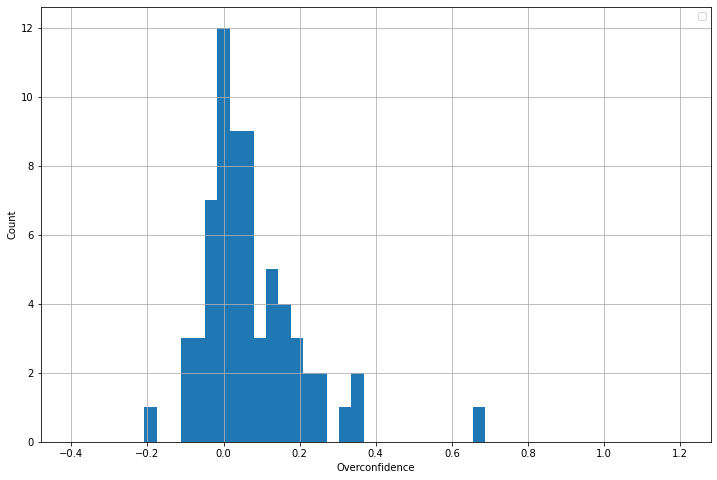

In [635]:
powerusers.Overconfidence.hist(bins=50,range=(-.4,1.2))
plt.ylabel("Count")
plt.xlabel("Overconfidence")
plt.legend()

No handles with labels found to put in legend.


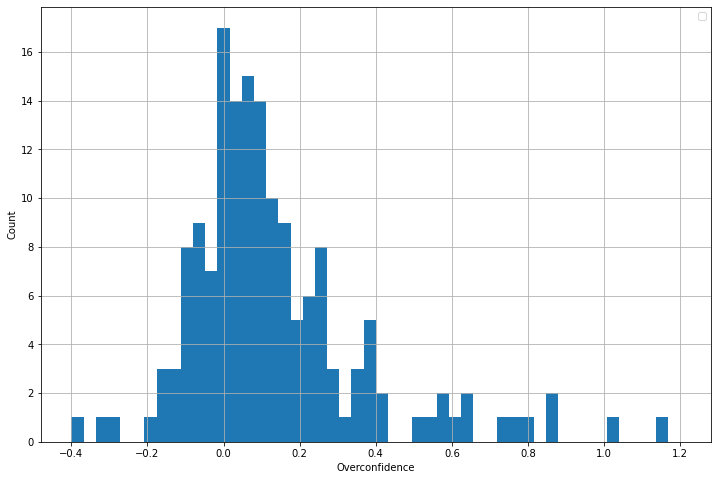

In [636]:
min26users.Overconfidence.hist(bins=50,range=(-.4,1.2))
plt.ylabel("Count")
plt.xlabel("Overconfidence")
plt.legend()

In [643]:
powerusers.sort_values("Qs", ascending=False).head(6)

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,AvgGBRBrier,Overconfidence
gwern,2282,2110,711.644,0.157,0.158,0.157,0.216,-0.009
JoshuaZ,2281,1789,498.946,0.142,0.149,0.143,0.228,-0.032
themusicgod1,1782,1647,399.711,0.187,0.192,0.188,0.225,-0.041
pranomostro,1500,1429,217.732,0.148,0.146,0.149,0.217,0.010
Cato,4301,1160,147.974,0.133,0.124,0.133,0.209,0.035
Jayson Virissimo,976,857,368.691,0.146,0.149,0.147,0.240,-0.015


In [156]:
powerusers.sort_values("AvgBrier").head(50)

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier
Temeraire,138,115,345.231431,0.080062,0.085518
Pablo Stafforini,229,187,235.463884,0.093000,0.081760
Emanuel Rylke,118,114,770.435883,0.095260,0.082452
Qiaochu,123,118,314.634617,0.095888,0.093218
amadeu,136,105,172.446990,0.101969,0.126119
kuudes,219,209,123.632445,0.103625,0.102859
Oscar_Cunningham,171,170,1001.508736,0.105789,0.096784
RobertLumley,153,148,525.103613,0.110429,0.119637
Nic_Smith,160,133,420.459808,0.110443,0.113369
Grognor,156,155,764.777615,0.112228,0.110657


In [753]:
preddict.shape

(47548, 12)

In [302]:
meta=dict()
for i in [0,1,2,3,4,7]:
    value_counts={}
    for key in preddict[preddict["PredFor"]>365*(i+1)].index:
        try:
            value_counts[key[1]]+=1
        except KeyError:
            value_counts[key[1]]=1
    meta[">"+str(i+1)+" years"]=[value_counts[1], value_counts[2], value_counts[5], value_counts[10]]     
    

In [303]:
meta

{'>1 years': [2692, 1960, 836, 253],
 '>2 years': [1351, 1055, 506, 150],
 '>3 years': [910, 734, 328, 90],
 '>4 years': [608, 453, 182, 58],
 '>5 years': [374, 260, 90, 27],
 '>8 years': [136, 82, 30, 6]}

In [304]:
metaframe=pd.DataFrame.from_dict(meta, orient="index", columns=["Questions", ">1 Pred", ">=5 Preds", ">=10 Preds"])

In [305]:
metaframe

,Questions,>1 Pred,>=5 Preds,>=10 Preds
>1 years,2692,1960,836,253
>2 years,1351,1055,506,150
>3 years,910,734,328,90
>4 years,608,453,182,58
>5 years,374,260,90,27
>8 years,136,82,30,6


In [861]:

groups=dict()


groups[1]=preddict[preddict.PredFor<365]
groups[2]=preddict[preddict.PredFor>365][preddict.PredFor<1095]
groups[3]=preddict[preddict.PredFor>1095][preddict.PredFor<1825]
groups[4]=preddict[preddict.PredFor>1825]
calibs=[k]
for group in groups.keys():
    calibs.append(calibrations(groups[group]))

In [693]:
for group in groups.keys():
    print(len(groups[group].index),np.mean(groups[group][["PredFor","Brier", "EBrier"]]))

36248 PredFor   106.125
Brier       0.162
EBrier      0.138
dtype: float64
7081 PredFor   626.547
Brier       0.162
EBrier      0.139
dtype: float64
2850 PredFor   1,421.784
Brier         0.149
EBrier        0.126
dtype: float64
1369 PredFor   2,545.791
Brier         0.140
EBrier        0.118
dtype: float64


## Pie charts of predictions by group over each time horizon

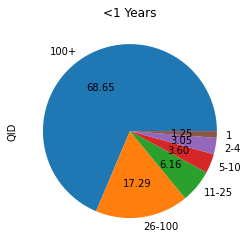

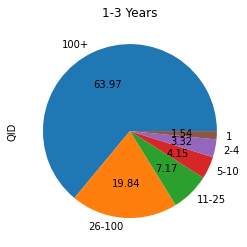

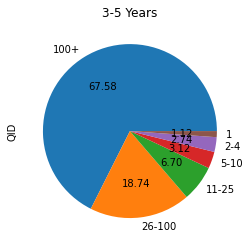

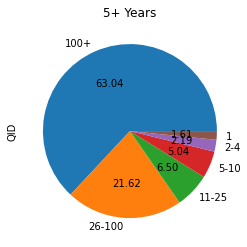

<Figure size 432x288 with 0 Axes>

In [714]:

plt.rcParams['figure.figsize'] = [6, 4]
v=groups[1].groupby("NumPredGroup")
v.count()["QID"].sort_values(ascending=False).plot.pie(autopct='%.2f', title="<1 Years")
plt.figure()
v=groups[2].groupby("NumPredGroup")
v.count()["QID"].sort_values(ascending=False).plot.pie(autopct='%.2f', title="1-3 Years")
plt.figure()
v=groups[3].groupby("NumPredGroup")
v.count()["QID"].sort_values(ascending=False).plot.pie(autopct='%.2f', title="3-5 Years")
plt.figure()
v=groups[4].groupby("NumPredGroup")
v.count()["QID"].sort_values(ascending=False).plot.pie(autopct='%.2f', title="5+ Years")
plt.figure()

plt.rcParams['figure.figsize'] = [12, 8]

In [699]:
overconfidence(groups[4]["OutcomeP"])

0.08172803651994742

<AxesSubplot:>

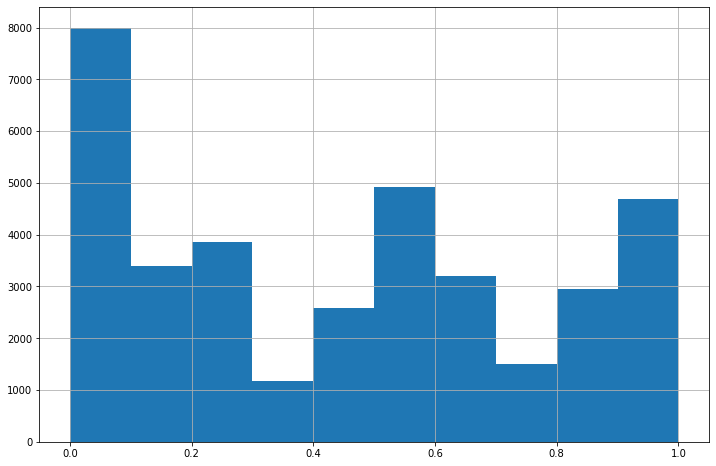

In [646]:
groups[1].Prediction.hist(bins=10)


<AxesSubplot:>

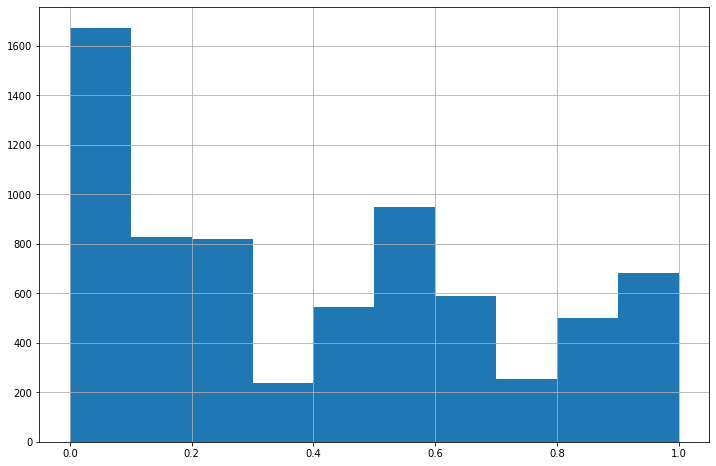

In [647]:
groups[2].Prediction.hist(bins=10)


<AxesSubplot:>

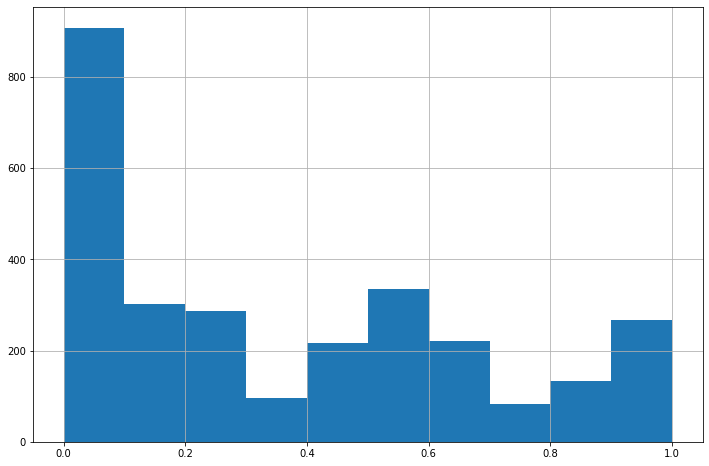

In [648]:
groups[3].Prediction.hist(bins=10)


<AxesSubplot:>

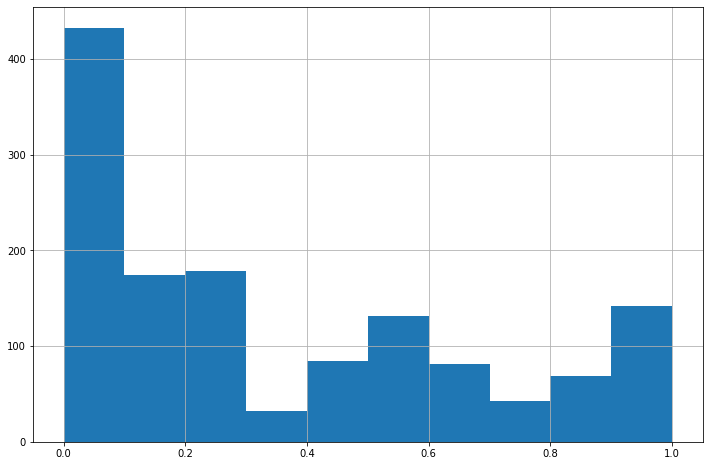

In [566]:

groups[4].Prediction.hist(bins=10)

## Calibration plots 

In [ ]:

b=pd.concat(calibs, axis=1)

<AxesSubplot:xlabel='Predicted Frequency', ylabel='Realised Frequency'>

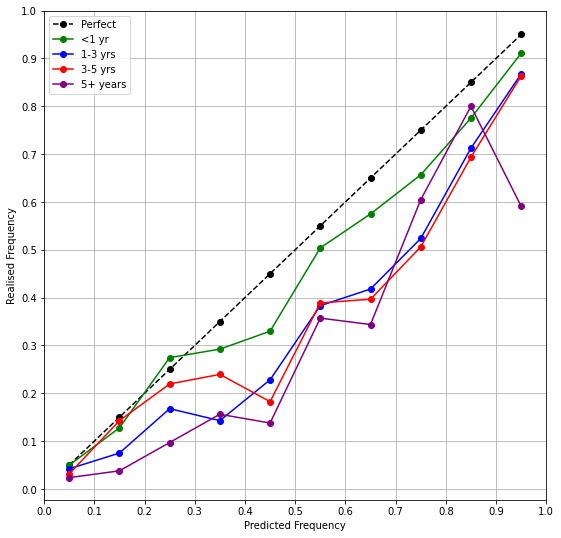

In [881]:

plt.rcParams['figure.figsize'] = [9, 9]
b.columns=["Perfect","<1 yr", "1-3 yrs", "3-5 yrs", "5+ years"]
b.plot.line(style=["--","-","-","-","-"],color=["black", "green", "blue", "red",  "purple"],grid=True, marker='o', xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency")

In [882]:
k=pd.Series(b.index, index=b.index)

## calibration by user prediction count

In [913]:

groups=dict()


groups[1]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs==1].index))]
groups[2]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>1][profiles.Qs<=4].index))]
groups[3]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>4][profiles.Qs<=10].index))]
groups[4]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>10][profiles.Qs<=25].index))]
groups[5]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>25][profiles.Qs<=100].index))]
groups[6]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>100].index))]

calibs=[k]
for group in groups.keys():
    calibs.append(calibrations(groups[group]))

In [914]:
for key in groups.keys():
    for i in range(10):
        bucket=groups[key][groups[key].Prediction>i/10.][groups[key].Prediction<i/10.+.1]
        print(len(bucket.index))
    print(len(groups[key].index), key)

64
19
26
24
6
9
25
53
41
69
709 1
186
46
77
36
17
26
69
79
54
116
1510 2
255
48
104
40
18
31
61
100
71
156
1839 3
502
102
242
78
59
74
132
184
115
242
3330 4
1455
398
555
230
192
303
336
389
278
608
9055 5
5590
1974
2386
1128
1455
1792
1415
1078
973
1789
31105 6


In [903]:
a=pd.concat(calibs, axis=1)

In [904]:

a.columns=["Perfect","<1","2-4", "5-10", "11-25", "26-100", ">100"]

In [877]:
a["Perfect"]=pd.Series([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95], index=a.index)

In [878]:
pd.Series([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])

0   0.050
1   0.150
2   0.250
3   0.350
4   0.450
5   0.550
6   0.650
7   0.750
8   0.850
9   0.950
dtype: float64

<AxesSubplot:xlabel='Predicted Frequency', ylabel='Realised Frequency'>

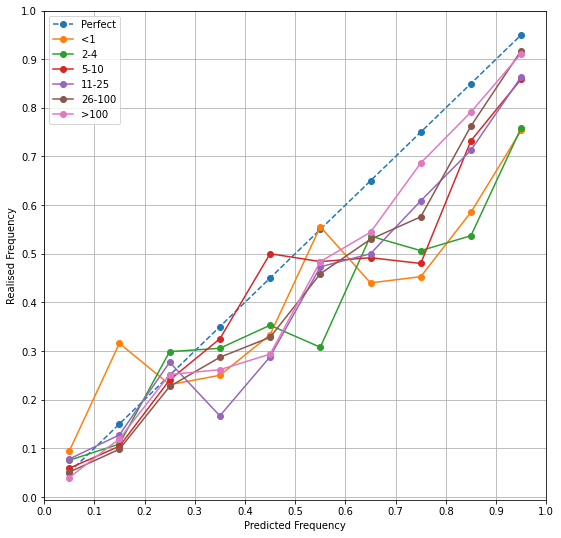

In [905]:
a.plot.line(style=["--","-","-","-","-","-","-"],grid=True, marker='o',xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency")

In [682]:

groups=dict()


# groups[1]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs==1].index))][preddict.PredFor>365]
groups[2]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs<=4].index))][preddict.PredFor>365]
groups[3]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>4][profiles.Qs<=10].index))][preddict.PredFor>365]
groups[4]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>10][profiles.Qs<=25].index))][preddict.PredFor>365]
groups[5]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>25][profiles.Qs<=100].index))][preddict.PredFor>365]
groups[6]=preddict[preddict.Predictor.apply(lambda x: x in list(profiles[profiles.Qs>100].index))][preddict.PredFor>365]

calibs=[]
for group in groups.keys():
    calibs.append(calibrations(groups[group]))

## Calibration by user prediction count for predictions over 1 year

In [ ]:
c=pd.concat(calibs, axis=1)

In [866]:

c.columns=["<5", "5-10", "11-25", "26-100", ">100"]
c["Perfect"]=pd.Series([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95], index=a.index)

<AxesSubplot:xlabel='Predicted Frequency', ylabel='Realised Frequency'>

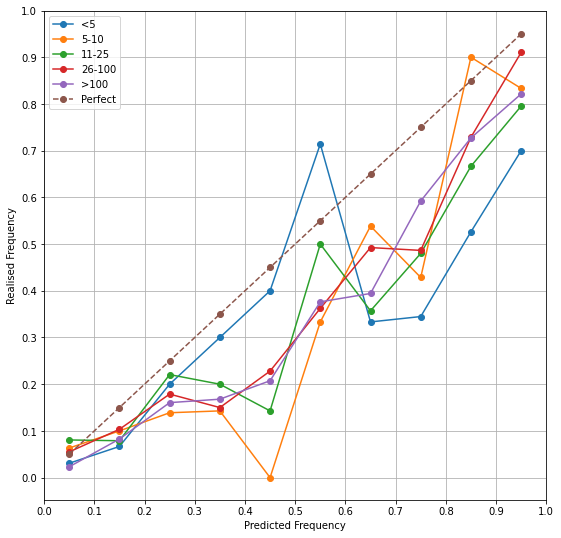

In [892]:
c.plot.line(style=["-","-","-","-","-","--"],grid=True, marker='o',xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency")

In [688]:
for key in groups.keys():
    for i in range(10):
        bucket=groups[key][groups[key].Prediction>i/10.][groups[key].Prediction<i/10.+.1]
        print(len(bucket.index))
    print(len(groups[key].index), key)

65
15
25
10
5
7
18
29
19
40
536 2
79
10
36
14
3
3
13
21
10
30
457 3
186
38
68
20
14
16
28
50
27
44
879 4
527
116
151
60
57
69
67
74
59
134
2356 5
1512
460
517
262
352
380
350
206
198
297
7072 6


## Sort frame by duration, then split in half and fit a linear model on one half, plot the other half after transforming it

In [805]:
preddict=preddict.sort_values("PredFor")

In [806]:
halfdf=preddict.loc[::2,:]

In [807]:
halfdf.NumPredGroup.unique()

array(['100+', '11-25', '26-100', '5-10', '1', '2-4'], dtype=object)

In [808]:
halfdf=halfdf[halfdf.NumPredGroup.apply(lambda x: x in ['100+',  '26-100'])]

In [809]:
halfdf.shape

(20366, 15)

In [810]:

groups=dict()


groups[1]=halfdf[halfdf.PredFor<365]
groups[2]=halfdf[halfdf.PredFor>365][halfdf.PredFor<1095]
groups[3]=halfdf[halfdf.PredFor>1095][halfdf.PredFor<1825]
groups[4]=halfdf[halfdf.PredFor>1825]
calibs=[k]
for group in groups.keys():
    calibs.append(calibrations(groups[group]))
d=pd.concat(calibs, axis=1)

In [811]:
from sklearn.linear_model import LinearRegression

In [812]:
adjustment=dict()
for i in range(1,5):
    X = d.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = d.iloc[:, i].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    adjustment[i]=(linear_regressor.coef_[0], linear_regressor.intercept_[0])

In [813]:
linear_regressor.intercept_[0]

-0.10894219713777503

In [814]:
otherhalfdf=preddict.iloc[1::2,:]

In [815]:
otherhalfdf=otherhalfdf[otherhalfdf.NumPredGroup.apply(lambda x: x in ['100+',  '26-100'])]

In [856]:
adjustment

{1: (array([0.93995759]), -0.015375173192954505),
 2: (array([0.9121884]), -0.10656828500941057),
 3: (array([0.89273411]), -0.08366703071484327),
 4: (array([0.85870517]), -0.10894219713777503)}

In [852]:
groups=dict()


groups[1]=otherhalfdf[otherhalfdf.PredFor<365]
groups[2]=otherhalfdf[otherhalfdf.PredFor>365][otherhalfdf.PredFor<1095]
groups[3]=otherhalfdf[otherhalfdf.PredFor>1095][otherhalfdf.PredFor<1825]
groups[4]=otherhalfdf[otherhalfdf.PredFor>1825]
calibs=[k]
for group in groups.keys():
    groups[group].Prediction=groups[group].Prediction.apply(lambda x: max(0.01,x*adjustment[group][0][0]+adjustment[group][1]))
    calibs.append(calibrations(groups[group]))
d=pd.concat(calibs, axis=1)

<AxesSubplot:xlabel='Predicted Frequency', ylabel='Realised Frequency'>

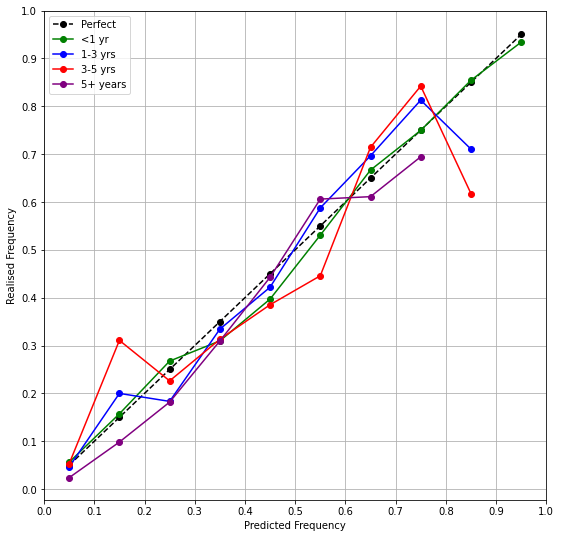

In [906]:

d.columns=["Perfect","<1 yr", "1-3 yrs", "3-5 yrs", "5+ years"]

d.plot.line(style=["--","-","-","-","-"],color=["black", "green", "blue", "red",  "purple"],grid=True, marker='o', xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency")

In [822]:
halfdf[halfdf.PredFor>1800][halfdf.Prediction>.9].shape

(50, 15)

In [828]:
calibrations(otherhalfdf[otherhalfdf.PredFor>365*5])

,0
0.050,0.019
0.150,0.065
0.250,0.082
0.350,0.118
0.450,0.214
0.550,0.385
0.650,0.375
0.750,0.588
0.850,0.875
0.950,0.607


In [911]:

groups=dict()
groups[1]=otherhalfdf[otherhalfdf.PredFor<365]
groups[2]=otherhalfdf[otherhalfdf.PredFor>365][otherhalfdf.PredFor<1095]
groups[3]=otherhalfdf[otherhalfdf.PredFor>1095][otherhalfdf.PredFor<1825]
groups[4]=otherhalfdf[otherhalfdf.PredFor>1825]
for key in groups.keys():
    for i in range(10):
        bucket=groups[key][groups[key].Prediction>i/10.][groups[key].Prediction<i/10.+.1]
        print(len(bucket.index))
    print(len(groups[key].index), key)

2490
940
1111
517
619
843
668
612
520
997
15599 1
551
192
216
111
119
148
130
93
96
132
2947 2
324
73
74
39
57
57
60
34
31
60
1220 3
155
31
49
17
14
13
16
17
8
28
576 4


In [912]:

groups=dict()


groups[1]=preddict[preddict.PredFor<365]
groups[2]=preddict[preddict.PredFor>365][preddict.PredFor<1095]
groups[3]=preddict[preddict.PredFor>1095][preddict.PredFor<1825]
groups[4]=preddict[preddict.PredFor>1825]
for key in groups.keys():
    for i in range(10):
        bucket=groups[key][groups[key].Prediction>i/10.][groups[key].Prediction<i/10.+.1]
        print(len(bucket.index))
    print(len(groups[key].index), key)

5683
1948
2593
1170
1316
1760
1562
1503
1219
2435
36248 1
1303
413
530
238
276
321
323
254
226
340
7081 2
729
147
164
96
126
126
121
83
62
139
2850 3
337
79
103
32
29
28
32
43
25
66
1369 4


In [843]:
otherhalfdf[otherhalfdf.PredFor>1825].shape

(576, 15)

In [533]:
powerusers=profiles[profiles.Count>100]

## Compare performance of earlier predictions to later predictions

In [909]:
initials=dict()
rest=dict()
initialscomp=dict()
restcomp=dict()
userperf=dict()
userperfcomp=dict()
for user in powerusers.index:
    initials[user]=byuser[user].head(50)
    inQIDs=initials[user].QID.unique()
    initialscomp[user]=preddict[preddict.QID.apply(lambda x:x in inQIDs)][preddict.Predictor.apply(lambda x:x != user)]
    rest[user]=byuser[user].tail(50)
    restQIDs=rest[user].QID.unique()
    restcomp[user]=preddict[preddict.QID.apply(lambda x:x in restQIDs)][preddict.Predictor.apply(lambda x:x != user)]
    
    userperf[user]=[np.mean(initials[user].Brier),np.mean(initials[user].EBrier),overconfidence(initials[user].OutcomeP),np.mean(rest[user].Brier),np.mean(rest[user].EBrier),overconfidence(rest[user].OutcomeP)]
    
    userperfcomp[user]=[np.mean(initialscomp[user].Brier),np.mean(initialscomp[user].EBrier),overconfidence(initialscomp[user].OutcomeP),np.mean(restcomp[user].Brier),np.mean(restcomp[user].EBrier),overconfidence(restcomp[user].OutcomeP)]

ZeroDivisionError: division by zero

In [ ]:
pd.DataFrame.from_dict(userperf, orient="index").mean()

In [ ]:
pd.DataFrame.from_dict(userperfcomp, orient="index").mean()

In [730]:
powerusers=profiles[profiles.Count>50]

In [731]:
initials=dict()
rest=dict()
initialscomp=dict()
restcomp=dict()
userperf=dict()
userperfcomp=dict()
for user in powerusers.index:
    initials[user]=byuser[user].head(10)
    inQIDs=initials[user].QID.unique()
    initialscomp[user]=preddict[preddict.QID.apply(lambda x:x in inQIDs)]
    rest[user]=byuser[user].head(50).tail(40)
    restQIDs=rest[user].QID.unique()
    restcomp[user]=preddict[preddict.QID.apply(lambda x:x in restQIDs)]
    
    userperf[user]=[np.mean(initials[user].Brier),np.mean(initials[user].EBrier),overconfidence(initials[user].OutcomeP),np.mean(rest[user].Brier),np.mean(rest[user].EBrier),overconfidence(rest[user].OutcomeP)]
    
    userperfcomp[user]=[np.mean(initialscomp[user].Brier),np.mean(initialscomp[user].EBrier),overconfidence(initialscomp[user].OutcomeP),np.mean(restcomp[user].Brier),np.mean(restcomp[user].EBrier),overconfidence(restcomp[user].OutcomeP)]

In [526]:
615+545*2.65+258*6.8+182*16.59+170*50.02+76*423.73

47539.91

In [527]:
615+545+258+182+170+76

1846

In [529]:
76*423.73/47540

0.6773975599495162

In [535]:
np.max(powerusers)

Count                 4301
Qs                    2110
AvgDuration      1,001.509
AvgBrier             0.317
AvgEBrier            0.196
AvgScaledBrier       0.300
Overconfidence       0.684
NumPredictions        100+
dtype: object

In [538]:
total=0
for u in profiles.index:
    total+=profiles.loc[user]["Count"]

In [556]:
preddict.Result.value_counts()

0.000    30118
1.000    17430
Name: Result, dtype: int64

In [557]:
17430/47548

0.3665769327837133

In [549]:
profiles.sort_values("Count", ascending=False).head(10)

,Count,Qs,AvgDuration,AvgBrier,AvgEBrier,AvgScaledBrier,Overconfidence,NumPredictions
Cato,4301,1160,147.974,0.133,0.124,0.133,0.035,100+
gwern,2282,2110,711.644,0.157,0.158,0.157,-0.009,100+
JoshuaZ,2281,1789,498.946,0.142,0.149,0.143,-0.032,100+
themusicgod1,1782,1647,399.711,0.187,0.192,0.188,-0.041,100+
Baeboo,1515,600,222.136,0.117,0.100,0.117,0.057,100+
pranomostro,1500,1429,217.732,0.148,0.146,0.149,0.010,100+
Tapetum-Lucidum,1207,553,184.395,0.121,0.102,0.120,0.062,100+
Jayson Virissimo,976,857,368.691,0.146,0.149,0.147,-0.015,100+
bobpage,944,739,389.819,0.113,0.103,0.113,0.035,100+
jbeshir,691,612,69.335,0.175,0.172,0.175,0.018,100+


In [545]:
np.sum(profiles)

Count                                                         47548
Qs                                                            38318
AvgDuration                                             597,042.322
AvgBrier                                                    403.760
AvgEBrier                                                   245.740
AvgScaledBrier                                              373.284
Overconfidence                                              768.963
NumPredictions    5-10100+100+100+5-10100+100+5-10100+100+100+10...
dtype: object

In [577]:
preddict.Result.unique()

array([0., 1.])

In [759]:
preddict["GroupBaseRate"]=preddict["NumPredGroup"].apply(lambda x: preddict.groupby("NumPredGroup").mean().loc[x]["Result"])

In [760]:
preddict["GBRBrier"]=(preddict["Result"]-preddict["GroupBaseRate"])*(preddict["Result"]-preddict["GroupBaseRate"])

In [595]:
preddict.groupby("NumPredGroup").mean()

,OpenFor,Result,Prediction,PredFor,Brier,EBrier,OutcomeP,ScaledPred,ScaledBrier,GroupBaseRate,GBRBrier
NumPredGroup,,,,,,,,,,,
1,368.923,0.416,0.602,325.198,0.245,0.130,0.626,0.539,0.220,0.416,0.243
100+,436.703,0.354,0.403,326.749,0.150,0.138,0.712,0.411,0.150,0.354,0.229
11-25,430.523,0.385,0.468,340.485,0.187,0.137,0.676,0.476,0.182,0.385,0.237
2-4,356.083,0.411,0.534,296.708,0.224,0.134,0.642,0.519,0.207,0.411,0.242
26-100,448.753,0.392,0.455,355.431,0.162,0.137,0.700,0.461,0.161,0.392,0.238
5-10,410.734,0.395,0.501,351.522,0.206,0.134,0.660,0.501,0.195,0.395,0.239
